<a href="https://colab.research.google.com/github/unrebby/data/blob/main/shw_02_cnn_AntonovaEvgeniya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

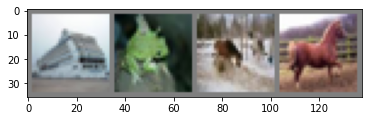

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [37]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()       
        self.sub_model0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32)
        )
        self.sub_model1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        )
        self.model = nn.Sequential(
            nn.ReLU()
        )
        self.avg_ = nn.Sequential(
            nn.AvgPool2d(kernel_size=(8, 8))
        )
        self.res_model = nn.Sequential(
            nn.Linear(in_features=512, out_features=n_classes)
        )


    def forward(self, x):
        sub_model0 = self.sub_model0(x)
        sub_model1 = self.sub_model1(x)
        out = self.model(sub_model0 + sub_model1)

        out = self.avg_(out)

        out = out.reshape(x.shape[0], 512)
        out = self.res_model(out)
        return out


In [38]:
net = BasicBlockNet()
net

BasicBlockNet(
  (sub_model0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (sub_model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (model): Sequential(
    (0): ReLU()
  )
  (avg_): Sequential(
    (0): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  )
  (res_model): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [39]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [41]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [85]:
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        
        pred = model(data)
        loss = criterion(pred, target)
        loss_log.append(loss.item())
        
        pred = torch.max(pred, 1)[1]
        acc = (pred == target).sum() / target.shape[0]
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        pred = model(data)
        loss = criterion(pred, target)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.item())

        pred = torch.max(pred, 1)[1]     
        acc = (pred == target).sum() / target.shape[0]  
      
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [45]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.1215306878961637, train acc: 0.6089628493546132
 val loss: 1.082240856962001, val acc: 0.6232712765957447

Epoch 1
 train loss: 1.0324564763571271, train acc: 0.6423592974978347
 val loss: 1.002061777672869, val acc: 0.6490469857733301

Epoch 2
 train loss: 0.9800107860478012, train acc: 0.6582658658079953
 val loss: 1.0206262659519276, val acc: 0.6506205672913409

Epoch 3
 train loss: 0.9426708723770852, train acc: 0.676416819012797
 val loss: 0.9682835992346419, val acc: 0.6706117021276595

Epoch 4
 train loss: 0.9162552893379706, train acc: 0.6826358057245258
 val loss: 0.9444519912942927, val acc: 0.6762632978723404

Epoch 5
 train loss: 0.8885134066262672, train acc: 0.6917031209037334
 val loss: 1.045063428168601, val acc: 0.6418439715466601

Epoch 6
 train loss: 0.8712585918210324, train acc: 0.6987423283308472
 val loss: 0.9459652548140668, val acc: 0.6755097518575952

Epoch 7
 train loss: 0.8574019496140141, train acc: 0.7027006071925818
 val loss: 0.933

Посчитайте точность на тестовой выборке:

In [46]:
loss_, acc_ = test(net, test_loader)
print("test accuracy:", acc_)

test accuracy: 0.6978503184713376


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [92]:
train_loss_log_mean = np.array(train_loss_log).reshape(20, -1)
train_acc_log_mean = np.array(train_acc_log).reshape(20, -1)

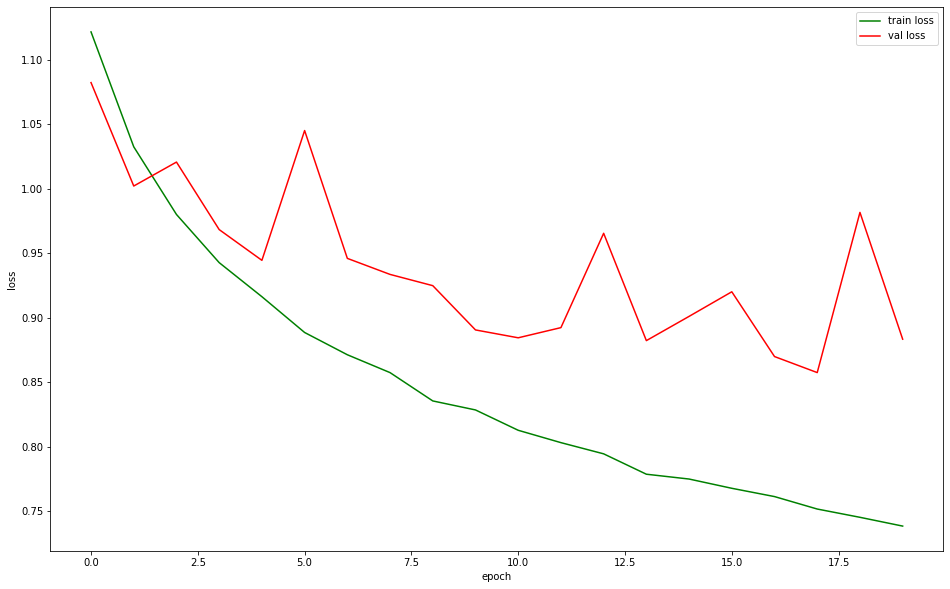

In [99]:
plt.figure(figsize=(16,10))
plt.plot((np.mean(train_loss_log_mean, axis=1)), label='train loss', color='green')
plt.plot(val_loss_log, label='val loss', color='red')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

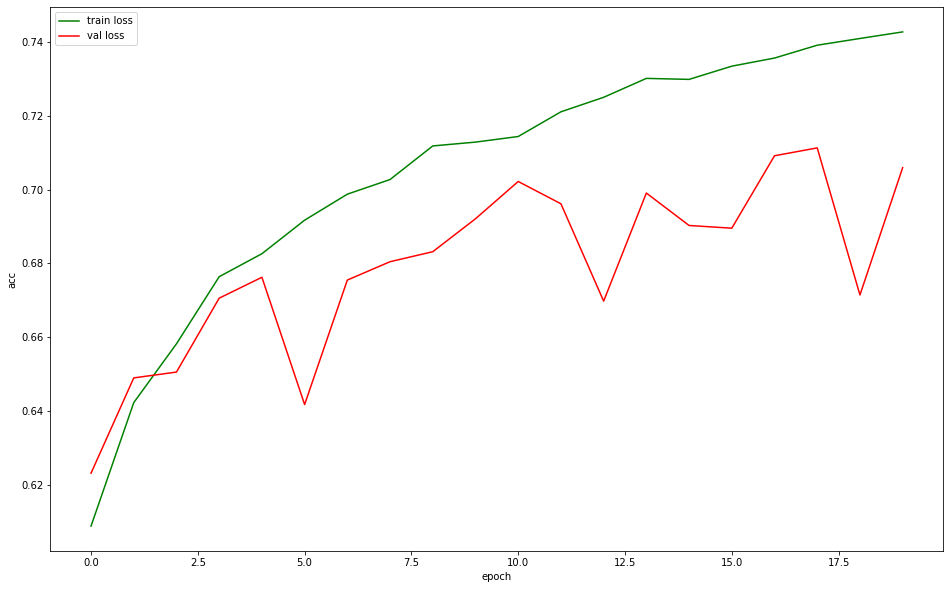

In [101]:
plt.figure(figsize=(16,10))
plt.plot((np.mean(train_acc_log_mean, axis=1)), label='train loss', color='green')
plt.plot(val_acc_log, label='val loss', color='red')

plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [102]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.467221056848383, train acc: 0.47827843436375395
 val loss: 1.211794201871182, val acc: 0.571187943346957

Epoch 1
 train loss: 1.1470167075694153, train acc: 0.5991650888427302
 val loss: 1.1673347584744718, val acc: 0.5945257093044037

Epoch 2
 train loss: 1.046716511467475, train acc: 0.6366422369231689
 val loss: 1.065708812754205, val acc: 0.6276817375041069

Epoch 3
 train loss: 1.000805521360045, train acc: 0.6525528859176845
 val loss: 1.065080191987626, val acc: 0.6364583332487878

Epoch 4
 train loss: 0.9525387624935868, train acc: 0.6712588142651309
 val loss: 1.0274254687288975, val acc: 0.6390514184819891

Epoch 5
 train loss: 0.9274595757942967, train acc: 0.6784898146196955
 val loss: 0.9598038381718574, val acc: 0.6677748226104898

Epoch 6
 train loss: 0.9073271601030116, train acc: 0.6880549751426446
 val loss: 0.9324520844094297, val acc: 0.6720523050490846

Epoch 7
 train loss: 0.8825813899092526, train acc: 0.6942902847007598
 val loss: 0.95451

Посчитайте точность на тестовой выборке:

In [104]:
loss_multistep, acc_multistep = test(net, test_loader)
print("test accuracy:", acc_multistep)

test accuracy: 0.7185509554140127


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [105]:
net_const = BasicBlockNet().to(device)
optimizer = optim.SGD(net_const.parameters(), lr=0.001, momentum=0.9)
tr_loss_log_const, tr_acc_log_const, val_loss_log_const, val_acc_log_const = train(net_const, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.830428861176946, train acc: 0.36198256727328465
 val loss: 1.6110806860822313, val acc: 0.44758421981588326

Epoch 1
 train loss: 1.5357335786278985, train acc: 0.4642000195640097
 val loss: 1.448108477288104, val acc: 0.4958776595744681

Epoch 2
 train loss: 1.4065967695804575, train acc: 0.5074758422331139
 val loss: 1.3559587250364589, val acc: 0.5205230496031172

Epoch 3
 train loss: 1.3274541066813077, train acc: 0.5375220358262768
 val loss: 1.291070733425465, val acc: 0.5472739361702128

Epoch 4
 train loss: 1.2682975364995395, train acc: 0.5560320906708838
 val loss: 1.2534075092762074, val acc: 0.5568484042553191

Epoch 5
 train loss: 1.2264214379260048, train acc: 0.5695759336952754
 val loss: 1.268875011231037, val acc: 0.549002659574468

Epoch 6
 train loss: 1.1858181785621853, train acc: 0.5856253265026936
 val loss: 1.1714125070166082, val acc: 0.5911790780564572

Epoch 7
 train loss: 1.1469977314990878, train acc: 0.6014951684357261
 val loss: 1.12

In [106]:
loss_const, acc_const = test(net_const, test_loader)
print("test accuracy:", acc_const)

test accuracy: 0.6713773885350318


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [112]:
net_step = BasicBlockNet().to(device)
optimizer = optim.SGD(net_step.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)
tr_loss_log_step, tr_acc_log_step, val_loss_log_step, val_acc_log_step = train(net_step, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4574286614083285, train acc: 0.4837180073126143
 val loss: 1.227741171451325, val acc: 0.5736702127659574

Epoch 1
 train loss: 1.1280730859235175, train acc: 0.605404478976234
 val loss: 1.1502185392887034, val acc: 0.5919104609083622

Epoch 2
 train loss: 1.0183747951247792, train acc: 0.6471622812900508
 val loss: 0.9743022974501265, val acc: 0.6621010638297873

Epoch 3
 train loss: 0.9708791053709208, train acc: 0.6641216701955638
 val loss: 0.9810070070814579, val acc: 0.6571143617021277

Epoch 4
 train loss: 0.9336127955909185, train acc: 0.6765188365575382
 val loss: 0.9609225090513838, val acc: 0.6710549646235527

Epoch 5
 train loss: 0.8140082361493294, train acc: 0.7183256071925818
 val loss: 0.8646194939917706, val acc: 0.7013519502700644

Epoch 6
 train loss: 0.7952085594481481, train acc: 0.7234183206636683
 val loss: 0.8553518143106014, val acc: 0.7047872340425532

Epoch 7
 train loss: 0.7851593408876625, train acc: 0.7287477148080439
 val loss: 0.8

In [113]:
loss_step, acc_step = test(net_step, test_loader)
print("test accuracy:", acc_step)

test accuracy: 0.710390127388535


In [108]:
net_exp = BasicBlockNet().to(device)
optimizer = optim.SGD(net_exp.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log_exp, tr_acc_log_exp, val_loss_log_exp, val_acc_log_exp = train(net_exp, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4955626543086886, train acc: 0.4668483937898109
 val loss: 1.2537180563236805, val acc: 0.5560062057160317

Epoch 1
 train loss: 1.111098668257105, train acc: 0.6137984787306359
 val loss: 1.0877307792927355, val acc: 0.6227171986661059

Epoch 2
 train loss: 1.0495178293048573, train acc: 0.6360260511882998
 val loss: 1.068466534766745, val acc: 0.6295212765957446

Epoch 3
 train loss: 1.0424670973687111, train acc: 0.6389070253485517
 val loss: 1.0664806655112733, val acc: 0.6319592199427017

Epoch 4
 train loss: 1.041453253852384, train acc: 0.638519358809295
 val loss: 1.0659082534465385, val acc: 0.6306959220703612

Epoch 5
 train loss: 1.0410118852716477, train acc: 0.6400781862260655
 val loss: 1.0669690286859552, val acc: 0.631161347602276

Epoch 6
 train loss: 1.0404006654645233, train acc: 0.6376216048732318
 val loss: 1.0660291537325433, val acc: 0.6303634752618505

Epoch 7
 train loss: 1.04180449683226, train acc: 0.6378297205381027
 val loss: 1.066364

In [109]:
loss_exp, acc_exp = test(net_exp, test_loader)
print("test accuracy:", acc_exp)

test accuracy: 0.6257961783439491


In [110]:
net_lin = BasicBlockNet().to(device)
optimizer = optim.SGD(net_lin.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
tr_loss_log_lin, tr_acc_log_lin, val_loss_log_lin, val_acc_log_lin = train(net_lin, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4845363604521185, train acc: 0.4676196461294861
 val loss: 1.2693310085763323, val acc: 0.5533687944107867

Epoch 1
 train loss: 1.194382115626466, train acc: 0.5810263776909934
 val loss: 1.095845709455774, val acc: 0.6187056738011381

Epoch 2
 train loss: 1.0702492577284302, train acc: 0.6239757443040991
 val loss: 1.084191322580297, val acc: 0.629720744680851

Epoch 3
 train loss: 1.0151986791403245, train acc: 0.6477335792790819
 val loss: 1.0599535016303367, val acc: 0.6270833333756062

Epoch 4
 train loss: 0.979013912638537, train acc: 0.6590044724004143
 val loss: 0.9945094965873881, val acc: 0.6562943263256803

Epoch 5
 train loss: 0.959711641345643, train acc: 0.6672311634424618
 val loss: 1.142074325490505, val acc: 0.614937943346957

Epoch 6
 train loss: 0.9226911632408825, train acc: 0.6823828023138169
 val loss: 0.9469056058437266, val acc: 0.6690602837724888

Epoch 7
 train loss: 0.8995947905388785, train acc: 0.6900137111517367
 val loss: 0.9471477

In [111]:
loss_lin, acc_lin = test(net_lin, test_loader)
print("test accuracy:", acc_lin)

test accuracy: 0.7109872611464968


Your answers here:

StepLR - домножает lr на gamma каждые эпохи step_size.

ExponentialLR - домножает lr на gamma на каждой эпохе.

LinearLR - уменьшает lr с помощью линейного изменения, пока не достигнет total_iters (по умолчанию равняется 5).

Качество с MultiStepLR практически такое же, как с LinearLR и StepLR.

In [126]:
print("test accuracy:")
print('MultiStepLR', acc_multistep)
print('ConstStep', acc_const)
print('StepLR', acc_step)
print('ExponentialLR', acc_exp)
print('LinearLR', acc_lin)

test accuracy:
MultiStepLR 0.7185509554140127
ConstStep 0.6713773885350318
StepLR 0.710390127388535
ExponentialLR 0.6257961783439491
LinearLR 0.7109872611464968


## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

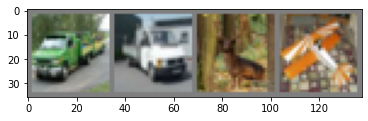

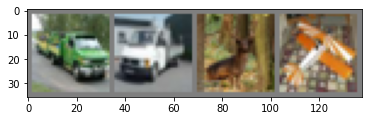

In [116]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [117]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4819886797742827, train acc: 0.4702149712407393
 val loss: 1.2828906394065696, val acc: 0.542686170212766

Epoch 1
 train loss: 1.1718023294068778, train acc: 0.5907506855575868
 val loss: 1.0860894307177118, val acc: 0.6218085106382979

Epoch 2
 train loss: 1.0493420785262337, train acc: 0.634552918469884
 val loss: 1.0349457794047416, val acc: 0.6427748226104899

Epoch 3
 train loss: 0.988633657177362, train acc: 0.6556746213266139
 val loss: 0.9488918682362171, val acc: 0.6703014183551708

Epoch 4
 train loss: 0.9485136664981598, train acc: 0.6702100744630999
 val loss: 0.986640795241011, val acc: 0.6560726949509154

Epoch 5
 train loss: 0.9171227563233872, train acc: 0.6824725776965265
 val loss: 0.934511373144515, val acc: 0.6756648936170213

Epoch 6
 train loss: 0.8961823125534999, train acc: 0.6920458996971521
 val loss: 0.9622439995725104, val acc: 0.6585992906955962

Epoch 7
 tra

Посчитайте точность на тестовой выборке:

In [118]:
loss_st, acc_st = test(net, test_loader)
print("test accuracy:", acc_st)

test accuracy: 0.7323845541401274


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [119]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 3)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net_gaussian = BasicBlockNet().to(device)
optimizer = optim.SGD(net_gaussian.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log_gaussian, tr_acc_log_gaussian, val_loss_log_gaussian, val_acc_log_gaussian = train(net_gaussian, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5491308300761026, train acc: 0.4477343953723663
 val loss: 1.3723073264385792, val acc: 0.5094414893617021

Epoch 1
 train loss: 1.291676700877969, train acc: 0.545544691778842
 val loss: 1.216273404943182, val acc: 0.5648492908224146

Epoch 2
 train loss: 1.1867649372142672, train acc: 0.5860293157793705
 val loss: 1.1488222758820716, val acc: 0.6020390071767442

Epoch 3
 train loss: 1.1283561292034616, train acc: 0.607253036071875
 val loss: 1.1017679323541356, val acc: 0.6197030140998515

Epoch 4
 train loss: 1.088924573805912, train acc: 0.6181117785478205
 val loss: 1.098326688370806, val acc: 0.6158909574468086

Epoch 5
 train loss: 1.0604785227470468, train acc: 0.6261752415618688
 val loss: 1.1102568486903577, val acc: 0.6108377659574468

Epoch 6
 train loss: 1.0406751363543314, train acc: 0.6371155980518138
 val loss: 1.0613520340716585, val acc: 0.6287234042553191

Epoch 7
 trai

In [120]:
loss_gaussian, acc_gaussian = test(net_gaussian, test_loader)
print("test accuracy:", acc_gaussian)

test accuracy: 0.673765923566879


In [121]:
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net_vert = BasicBlockNet().to(device)
optimizer = optim.SGD(net_vert.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log_vert, tr_acc_log_vert, val_loss_log_vert, val_acc_log_vert = train(net_vert, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.655293609586015, train acc: 0.4009614129171075
 val loss: 1.4602696089034384, val acc: 0.4692154255319149

Epoch 1
 train loss: 1.3935556470585044, train acc: 0.5024402585609303
 val loss: 1.2906135280081565, val acc: 0.5420877659574468

Epoch 2
 train loss: 1.2832100153841093, train acc: 0.5409375815984317
 val loss: 1.2912173245815521, val acc: 0.5438829787234043

Epoch 3
 train loss: 1.2271721663815012, train acc: 0.565140212802608
 val loss: 1.1888816486013696, val acc: 0.5824468085106383

Epoch 4
 train loss: 1.1780315209350376, train acc: 0.5831075346121186
 val loss: 1.2084132161546262, val acc: 0.5730939715466601

Epoch 5
 train loss: 1.146031219845934, train acc: 0.5970023178531221
 val loss: 1.18217480081193, val acc: 0.5808510638297872

Epoch 6
 train loss: 1.1134056768208143, train acc: 0.6074448288903593
 val loss: 1.1471915186719692, val acc: 0.594437056653043

Epoch 7
 trai

In [122]:
loss_vert, acc_vert = test(net_vert, test_loader)
print("test accuracy:", acc_vert)

test accuracy: 0.6583399681528662


In [123]:
transform = transforms.Compose(
        [transforms.RandomInvert(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net_inv = BasicBlockNet().to(device)
optimizer = optim.SGD(net_inv.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log_inv, tr_acc_log_inv, val_loss_log_inv, val_acc_log_inv = train(net_inv, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7391449208669296, train acc: 0.3826227474692099
 val loss: 1.49296843193947, val acc: 0.46961436170212767

Epoch 1
 train loss: 1.4070344726389896, train acc: 0.5099650692242373
 val loss: 1.3274750879470338, val acc: 0.5399157801841168

Epoch 2
 train loss: 1.2756804444672203, train acc: 0.5601699202980376
 val loss: 1.2273966028335246, val acc: 0.5779476949509154

Epoch 3
 train loss: 1.204901380338442, train acc: 0.5867556803187243
 val loss: 1.1780128329358202, val acc: 0.6001551417594261

Epoch 4
 train loss: 1.1546362551300355, train acc: 0.6026091995143368
 val loss: 1.2018818043647927, val acc: 0.5849512412192973

Epoch 5
 train loss: 1.128001166109193, train acc: 0.6127374967665733
 val loss: 1.1459556292980275, val acc: 0.6088652481424047

Epoch 6
 train loss: 1.1016595457328084, train acc: 0.6231922499658421
 val loss: 1.1070203471691051, val acc: 0.6184840425531914

Epoch 7
 t

In [124]:
loss_inv, acc_inv = test(net_inv, test_loader)
print("test accuracy:", acc_inv)

test accuracy: 0.6660031847133758


Your answers here:

GaussianBlur - размывает изображение с помощью случайно выбранного размытия по Гауссу.

RandomVerticalFlip - переворачивает изображение по вертикали случайным образом с заданной вероятностью (по умолчанию 0.5).

RandomInvert - инвертирует цвета изображения случайным образом с заданной вероятностью (по умолчанию 0.5).

Лучшее качество получилось с RandomHorizontalFlip.

In [125]:
print("test accuracy:")
print('RandomHorizontalFlip', acc_st)
print('GaussianBlur', acc_gaussian)
print('RandomVerticalFlip', acc_vert)
print('RandomInvert', acc_inv)

test accuracy:
RandomHorizontalFlip 0.7323845541401274
GaussianBlur 0.673765923566879
RandomVerticalFlip 0.6583399681528662
RandomInvert 0.6660031847133758


## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>